# Graduate Climate Conference 2022 - Climate + Machine Learning Workshop
--> [***Colab link***](https://githubtocolab.com/salvaRC/GCC2022-climate-machine-learning-workshop/blob/master/GCC-Climate-ML-workshop.ipynb) to run the notebook yourself on a GPU.

In this notebook, we'll be going through an exemplary, self-contained machine learning (ML) pipeline.
Here, we'll be training a neural network to forecast daily sea surface temperatures (SST) in the Pacific Ocean. The data we will be using is from the [NOAA OISSTv2](https://psl.noaa.gov/data/gridded/data.noaa.oisst.v2.highres.html) dataset, which is a gridded dataset covering SSTs from $1982$ to $2022$ at a $0.25^\circ$ resolution. We will be using the [xarray](http://xarray.pydata.org/en/stable/) library to read in the data, and [PyTorch Lightning](https://www.pytorchlightning.ai/) -- a useful abstraction layer on top of PyTorch -- to train our neural network model.

**Note:** To reproduce or understand how exactly we have downloaded and preprocessed the data, have a look at [this github folder & the instructions therein](https://github.com/salvaRC/GCC2022-climate-machine-learning-workshop/tree/master/dataset_creation).


### Install libraries and download data

In [1]:
!pip install netCDF4 dask xarray pytorch_lightning torchmetrics wandb zenodo_get
!zenodo_get 7259555  # download the data from zenodo (from https://zenodo.org/record/7259555)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Title: GCC2022 - OISSTv2 standardized daily SST
Keywords: oisstv2
Publication date: 2022-10-27
DOI: 10.5281/zenodo.7259555
Total size: 2252.6 MB

Link: https://zenodo.org/api/files/be5e1d86-3514-4bcf-ac85-88117e5cb12d/sst.day.mean.box108.nc   size: 204.8 MB
sst.day.mean.box108.nc is already downloaded correctly.

Link: https://zenodo.org/api/files/be5e1d86-3514-4bcf-ac85-88117e5cb12d/sst.day.mean.box109.nc   size: 204.8 MB
sst.day.mean.box109.nc is already downloaded correctly.

Link: https://zenodo.org/api/files/be5e1d86-3514-4bcf-ac85-88117e5cb12d/sst.day.mean.box110.nc   size: 204.8 MB
sst.day.mean.box110.nc is already downloaded correctly.

Link: https://zenodo.org/api/files/be5e1d86-3514-4bcf-ac85-88117e5cb12d/sst.day.mean.box111.nc   size: 204.8 MB
sst.day.mean.box111.nc is already downloaded correctly.

Link: https://zenodo.org/api/files/be5e1d86-3514-4bcf-ac85-88117e5cb12d/sst.day

In [2]:
DATA_DIR = './'  # folder where the data is stored (PLEASE ADJUST if you store the data elsewhere)

## Some ML terminology 
*Note:* feel free to skip and come back to this as needed
- **Model**: We will often refer to the neural network model simply as the "model". We use the model to learn a function. Here, we'll try to learn a function that maps the input data (e.g. SSTs from one day) to the output data (e.g. SSTs of the next day). A model is composed of multiple layers and non-linear activation functions.
- **Layer**: A layer is a subcomponent of a model that performs a specific function. For example, a layer might be a simple matrix multiplication (i.e. linear transformation of the input data). Other popular layers include convolutional layers, normalization layers (e.g. [LayerNorm](https://arxiv.org/abs/1607.06450)), self-attention layers, etc.
- **Activation functions** are key non-linearities that enable the model to learn complex functions (if we only used linear functions, we would only be able to learn linear functions). For example, the [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) and [GELU](https://arxiv.org/abs/1606.08415) activation functions are popular choices.
- **Model architecture and parameters**: A model is defined by its architecture (e.g. the number of layers, the type of layers, etc.) and its parameters (i.e. the learnable weights in each layer). Popular architectures include fully-connected neural networks (also known as MLPs, i.e. multi-layer perceptrons), [LSTM](https://en.wikipedia.org/wiki/Long_short-term_memory), convolutional neural net (CNN), [ResNet](https://arxiv.org/abs/1512.03385), [Transformer](https://arxiv.org/abs/1706.03762), [ConvNext](https://openaccess.thecvf.com/content/CVPR2022/papers/Liu_A_ConvNet_for_the_2020s_CVPR_2022_paper.pdf), etc.
- **Training**: The process of learning the function. This is done by optimizing the model's parameters/weights to minimize the loss function.
- **Loss function**: A function that measures how well the model is performing. The loss function is used to optimize the model's parameters. Here, we'll use the mean squared error (MSE) between the model's predictions and the true SSTs.
- **Targets**: Refers to the data to-be--predicted by the model. This is usually the ground truth outputs of the function that we aim to learn. Also known as *labels* (in the classification setting).
- **Training loop**: The process of training the model. In each iteration of the training loop, we feed a subset of data into the model, compute the loss, and update the model's parameters.
- **Batch size**: The number of data points/examples that are fed into the model at once at any given iteration of the training loop.
- **Epoch**: One epoch means iterating over the training set once.  We often train the model for multiple epochs to improve the model's performance.
- **Learning rate**: The step size used to update the model's parameters.
- **Optimizer**: The algorithm used to update the model's parameters. Here, we'll be using the [Adam](https://arxiv.org/abs/1412.6980) optimizer.
- **Hyperparameters**: The parameters that are used to define & set up the model and training loop (e.g. the model architecture, loss function, learning rate etc.). These are often tuned on a validation set to improve the model's performance.
- **Channels**: The number of channels in a data example (also denoted as *feature* or *hidden* dimension). For example, an RGB image has 3 channels (one for each color). Here, we will be using SSTs only, so we will have 1 channel/feature.
- **Classification vs. regression**: ML differentiates between these two tasks. In classification, the model's output is a discrete label (e.g. a class, a word, classifying whether an extreme event happened or not, etc.). In regression, the model's output is a continuous value (e.g. a temperature).
- **Overfitting**: When the model performs well on the training data, but poorly on the validation data (as measured by the loss function or some other metric).


In [3]:
# Import libraries
import os
import time
import multiprocessing
from typing import List, Tuple, Dict, Any, Union, Optional
import numpy as np
import xarray as xr
import torch
import torchmetrics
import pytorch_lightning as pl

## Data

The creation of a dataset for ML training is often an iterative approach.
It is important to understand the data and the data sources, ensure that the data is of high quality, and that the data is representative of the problem domain.

Here, we'll use daily SST data from the NOAA OISSTv2 dataset, which have been downloaded above already. For convenience, the data have been pre-processed slightly already. Concretely, we subdivided the data into $60\times60$ lat$\times$lon grid tiles and chose 11 of those boxes from the tropical Pacific as the data for this tutorial. The 11 boxes are shown with their box IDs (84-89 and 108-112) in the image below.
![](https://drive.google.com/uc?export=view&id=1DfHE9e8gbTbrCW39JjvhheSMjspKFeA3)

In [4]:
# Each file contains daily SST data from 1982 to 2022 from a 60x60 (lat, lon) grid box (each of the 11 boxes is in the tropical Pacific)
xr.open_dataset(os.path.join(DATA_DIR, 'sst.day.mean.box85.nc')).sst  # print an example SST box

<xarray.DataArray 'sst' (time: 14894, lat: 60, lon: 60)>
[53618400 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 1982-01-01 1982-01-02 ... 2022-10-11
  * lat        (lat) float32 -14.88 -14.62 -14.38 ... -0.625 -0.375 -0.125
  * lon        (lon) float32 195.1 195.4 195.6 195.9 ... 209.1 209.4 209.6 209.9
    dayofyear  (time) int64 ...


#### Potential data issues
While the data that we'll use in this tutorial was chosen partly to be able to accurately train ML models in an uncomplicated manner, it is important to be aware of potential pitfalls (and how to address them!) that may arise when using different data:

- ***Data imbalance*** occurs when some data slices/classes are more common than others in the training dataset. This can lead the model to learn to predict the more common data slices and perform poorly on the less common data slices (e.g. extreme events). Ways to address this issue include:
    - *Oversampling* the less common data slices or *undersampling* the more common data slices during training
    - *Weighting the loss function* to give more importance to the less common data slices
    - Learning a *probabilistic model* (e.g. a generative adversarial net (GAN) usually produces more realistic samples than a deterministic neural network)
- ***Data scarcity*** occurs when there is not enough data to accurately train a model (neural networks can be very data hungry!). Ways to address this issue include:
    - *Transfer learning* (i.e. fine-tuning/using a model pre-trained on a similar problem domain)
    - *Data augmentation* (e.g. by adding noise to the data)
    - *Simpler models* (e.g. by using a model with fewer parameters, or other model classes such as linear models, random forests etc.)

#### Splitting the data
It is important to split the data into *separate* training, validation, and test sets.
- The *training set* is used to train the model (i.e. learn the weights/parameters of the model)
- The *validation set* is used to tune the model hyperparameters, preventing overfitting, and to select the best model(s).
- The *test set* is used to evaluate the performance of the selected model(s) on data that the model has not seen before. Testing is done <u>*after*</u> model selection.

**Super important:** For temporal data *always* split your data temporally!
E.g.:
- In forecasting you may use data from 1982-2018, 2019, 2020-21 for training, validation, and testing, respectively as is done here.
- Or, in the exemplary task of evaluating how robust an ML model is to changing atmospheric conditions due the Mt Pinatubo eruption in 1991, one might train on data from 1980-2000 taking care of removing not only 1991 but also 1992-93 from the training set since the eruption is known to have had long-lasting effects on the climate.


In [5]:
# Define the temporal slices that will be used for training, validating, and testing
# Important: training data should not contain data that is temporally near the test data (to remove autocorrelation issues)
TRAIN_SLICE = slice(None, '2018-12-31')
VAL_SLICE   = slice('2019-01-01', '2019-12-31')
TEST_SLICE  = slice('2020-01-01', '2021-12-31')

### Data preprocessing
Data preprocessing is the process of transforming the raw data into a form that is more suitable for ML training.
It's often an iterative process (e.g. deciding how to normalize the data), and a time-consuming part of the ML pipeline. Some common preprocessing steps are:
- ***Standardization & Normalization:*** Usually one subtracts the mean and divides by the standard deviation. For climate data you often want to use daily/monthly/seasonal means and standard deviations to *remove the seasonal cycle*. When computing data statistics such as the mean, <u>always compute them on the training set only</u>. <br>
Data variables that follow a skewed distribution (e.g. precipitation) are often (first) normalized by applying, e.g., the *log* function.
- ***Missing data and Outliers:*** Missing data and outliers can be handled by *removing* the corresponding data slices. One may also resort to *imputing* the missing data (e.g. by using the mean value), or *clipping* the outliers (e.g. by setting the values of the outliers to some minimum/maximum value).
- ***Reshaping Dimensions:*** Neural networks expect their input data to be in very specific shapes and ordered dimensions. For example:
    - 2D convolutional neural net's (CNN) expect the input data to be of shape `(batch_size, channels, height, width)`. Note that for gridded climate data, ``height = latitude``, ``width = longitude``, and ``channels`` might consist of one or more predictors (e.g. SSTs, radiative fluxes, etc.)
    - An MLP expects its input data to be of shape `(batch_size, features)`. Note that an MLP can always be easily applied by flattening all dimensions into a single feature dimension, e.g. for the CNN example above: ``features = height * width * channels``
    - Transformer's usually expect the input data to be of shape `(batch_size, sequence_length, features)`. Originally, sequence length referred to the number of token (think of words). For image and climate data, one can build the sequence dimension by flattening the spatial dimensions, e.g. for the CNN example above: ``sequence_length = height * width = lat * lon`` and ``features = channels``. However, other choices are possible, such as patching the image/grid into multiple sub-images/grids and using the patches as the sequence dimension (see e.g. [ViT](https://arxiv.org/abs/2010.11929), or NVIDIA's weather forecasting model, [FourCastNet](https://arxiv.org/abs/2202.11214)).

#### Preprocessing our data
Here, the downloaded data already has been preprocessed with the first two steps. Concretely, we have standardized the raw SSTs based on their daily means and standard deviations (computed on the training set, i.e. 1982-2018), and filled missing values (i.e. continental regions) with zeroes.

We still need to perform step 3 though, which is done below in the ``setup`` method. Since we'll be using a CNN as our ML model later, we reshape the SST data to the needed ``(data-examples, channels, lat, lon)`` shape. Here, ``data-examples`` consists of the concatenation of all timesteps (for the corresponding train/val/test set) and all 11 grid-boxes, while ``channels=1`` since SSTs are our only data variable, and ``lat=lon=60``.

In addition, we need to
- create the target data for the to-be-trained CNN. Here, we'll predict the next time step (i.e. next day) of SSTs using the current time step as input,
- transform the nextdf4/xarray data format to PyTorch tensors (we do this through the route xarray -> numpy -> pytorch),
- define how pytorch will load our created (input, target) data pairs. This is all defined in the *_dataloader methods below. They are not too important for now though, and you can usually simply reuse the exact same methods for other datasets.

In [6]:
from torch.utils.data import DataLoader, TensorDataset
import dask

class OISSTv2DataModule(pl.LightningDataModule):
    """
    Data module for the OISSTv2 dataset of daily sea surface temperatures.
    A data module encapsulates the data loading, preprocessing, and data splits needed for training, validation, and testing a neural network model.
    These generated PyTorch-ready TensorDataset's are saved in the self._data_train, self._data_val, and self._data_test attributes when calling the setup() function.
    """
    _data_train: TensorDataset
    _data_val: TensorDataset
    _data_test: TensorDataset

    def __init__(self, data_dir: str, horizon: int = 1,  batch_size: int = 32, eval_batch_size: int = 64):
        """
        Args:
            data_dir (str):  A path to the data folder that contains the input and output files.
            horizon (int): The number of time steps to predict into the future (e.g. 1 for 1 day ahead prediction).
            batch_size (int): Batch size for the training dataloader
            eval_batch_size (int): Batch size for the test and validation data loader's
        """
        super().__init__()
        # The following saves all arguments to self.hparams (e.g. self.hparams.horizon)
        self.save_hyperparameters()
        # Set the currently non-initialized tensor datasets for training, validating, testing
        self._data_train = self._data_val = self._data_test = None


    def setup(self, stage: Optional[str] = None):
        """ Setup data. Set internal variables: self._data_train, self._data_val, self._data_test."""
        if self._data_train and self._data_val and self._data_test:
          return # No need to setup again
        # A small auxiliary function to preprocess the netcdf4 data
        def drop_lat_lon_info(ds: xr.Dataset) -> xr.Dataset:
            """ Drop latitude and longitude coordinates so that xarray datasets can be
             concatenated/merged along (example, grid_box) instead of (lat, lon) dimensions. """
            dummy_lat = np.arange(ds.sizes['lat'])
            dummy_lon = np.arange(ds.sizes['lon'])
            return ds.assign_coords(lat=dummy_lat, lon=dummy_lon)

        # Read all 60x60 boxes into a single xarray dataset
        ds = xr.open_mfdataset(
            paths=os.path.join(self.hparams.data_dir, 'sst.day.mean.box*.nc'),
            combine='nested', concat_dim='grid_box', preprocess=drop_lat_lon_info
        ).sst

        # Split the dataset into training, validation, and testing
        data_splits = {
            'train': ds.sel(time=TRAIN_SLICE),
            'val': ds.sel(time=VAL_SLICE),
            'test': ds.sel(time=TEST_SLICE)
        }
        # Create a TensorDataset for each split (here, we perform the same preprocessing for each split)
        for split_name, split_data_subset in data_splits.items():
            # Split ds into inputs and targets (targets is horizon time steps ahead of inputs)
            inputs  = split_data_subset.isel(time=slice(None, -self.hparams.horizon))
            targets = split_data_subset.isel(time=slice(self.hparams.horizon, None))
            # Dimensions of X and Y: (grid-box, time, lat, lon)

            def transform(x: xr.DataArray) -> torch.Tensor:
                """ Transform the input and target data to the desired format. """
                with dask.config.set(**{'array.slicing.split_large_chunks': False}):
                    x = x.stack(examples=('time', 'grid_box'))  # Merge the time and grid_box dimensions into a single example dimension (new dimensions: (examples, lat, lon))
                x = x.transpose('examples', 'lat', 'lon').values   # Reorder/Reshape dimensions and convert to numpy array
                x = np.expand_dims(x, axis=1)    # Add a dummy channel dimension (needed for CNNs, Transformers, etc.)
                # Dimensions of x: (examples, channel, lat, lon) = (example, 1, 60, 60)
                x = torch.from_numpy(x).float()  # Convert to PyTorch tensor
                return x

            # Transform the inputs and targets (in this case, the same transformation is applied to both)
            inputs = transform(inputs)
            targets = transform(targets)

            # Create the pytorch tensor dataset, which will return a tuple of (input, target) when indexed
            tensor_ds = TensorDataset(inputs, targets)
            setattr(self, f'_data_{split_name}', tensor_ds)  # Save the tensor dataset to self._data_{split_name}

    # ----- Data loaders -----
    # Basically, data loaders just wrap the corresponding TensorDataset's in a pytorch DataLoader (e.g. defines the batch size)
    # Important: You usually shuffle the training data, but not the validation and test data!
    def _shared_dataloader_kwargs(self) -> dict:
        return dict(num_workers=multiprocessing.cpu_count(), pin_memory=True)  # Use multiprocessing and pin memory for faster data loading

    def train_dataloader(self) -> DataLoader:
        return DataLoader(
            dataset=self._data_train,
            batch_size=self.hparams.batch_size,
            shuffle=True,
            **self._shared_dataloader_kwargs(),
        )

    def _shared_evaluation_dataloader_kwargs(self) -> dict:
        # Disable shuffling and potentially use a larger batch size for evaluation
        return dict(**self._shared_dataloader_kwargs(), batch_size=self.hparams.eval_batch_size, shuffle=False)

    def val_dataloader(self) -> DataLoader:
        return DataLoader(dataset=self._data_val, **self._shared_evaluation_dataloader_kwargs())

    def test_dataloader(self) -> DataLoader:
        return DataLoader(dataset=self._data_test, **self._shared_evaluation_dataloader_kwargs())


## Define the model

We will use a simple convolutional neural net, ConvNet, as our ML model. However, one could explore using different models such as more advanced ConvNet's (e.g. a ResNet or ConvNext), or different architectures such as vision transformers.
Our model is composed of 3 ConvBlock's -- which consist of a 2D convolution (see [this link for a visualization](https://images.squarespace-cdn.com/content/v1/5a8dbb09bff2006c33266320/1538257989147-MK4591YBPF8WN2Y2X36E/image-asset.gif?format=1500w) of how a convolution operates), a normalization layer, and a non-linear activation function -- and a output layer called ``head`` which makes the final prediction of the next-day SSTs.

In [7]:
import torch.nn as nn

class ConvBlock(nn.Module):
    """ A simple convolutional block with BatchNorm and GELU activation. """
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int = 3, stride: int = 1, padding: int = 1):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.norm = nn.BatchNorm2d(out_channels)  # a normalization layer for improved/more stable training
        self.activation = nn.GELU()  # a non-linearity

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv(x)
        x = self.norm(x)
        x = self.activation(x)
        return x

class ConvNet(nn.Module):
    """ A simple convolutional network. """

    def __init__(self, channels_in, channels_out, channels_hidden):
        super().__init__()
        dim = channels_hidden
        # Define the convolutional layers
        self.conv1 = ConvBlock(channels_in, dim, kernel_size=3, padding=1)
        self.conv2 = ConvBlock(dim, dim, kernel_size=3, padding=1)
        self.conv3 = ConvBlock(dim, dim // 2, kernel_size=3, padding=1)
        self.head = nn.Conv2d(dim // 2, channels_out, kernel_size=1, padding=0)


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        h1 = self.conv1(x)
        h2 = self.conv2(h1)
        h2 = h1 + h2  # Residual connection
        h3 = self.conv3(h2)
        h4 = self.head(h3)
        return h4

    

## Define the LightningModule (i.e. how to train the model)

In [8]:
class LitConvNet(pl.LightningModule):
    def __init__(self, hidden_dim: int = 32, learning_rate: float = 1e-3, **kwargs):
        super().__init__()
         # Save the hyperparameters to self.hparams
        self.save_hyperparameters() 

        # Define the neural network architecture
        # channels_in = channels_out = 1 because inputs and outputs consist of a single variable, i.e. SSTs
        self.model = ConvNet(channels_in=1, channels_out=1, channels_hidden=hidden_dim)  

        # The loss function. The mean squared error is the usual go-to for regression
        self.loss_function = nn.MSELoss()

        # Some metrics to track during/after training. Here you should add any metrics that help you judge the model's performance on evaluation data.
        self.val_metrics = nn.ModuleDict({'val/mae': torchmetrics.MeanAbsoluteError()})
        self.test_metrics = nn.ModuleDict({'test/mae': torchmetrics.MeanAbsoluteError()})

        self._start_epoch_time = None  # To track how long each training epoch takes

    # ---------------------------------------------- Training methods START
    def on_train_start(self):
        # Compute the number of parameters in the model and log it
        num_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        self.log('num_params', float(num_params))

    def on_train_epoch_start(self):
        self._start_epoch_time = time.time()

    def training_step(self, batch: Tuple[torch.Tensor, torch.Tensor], batch_idx: int) -> dict:
        """ Defines a single training loop/iteration over one batch of training data. """
        x, y = batch   # x = inputs, y = targets (or ground truth)
        y_hat = self.model(x)  # y_hat = model predictions
        loss = self.loss_function(y_hat, y)
        self.log('train/loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        # the returned loss below will be used by Pytorch Lightning to update the model weights
        return {'loss': loss}  

    def training_epoch_end(self, outputs: List[Any]):
        train_time = time.time() - self._start_epoch_time  # Time spend in training epoch
        self.log("time_train", train_time)
    # ------------------------------------------------ Training methods END

    def evaluation_step(self, batch: Tuple[torch.Tensor, torch.Tensor],
                        batch_idx: int,
                        torch_metrics: nn.ModuleDict,
                        split_name: str, # 'val' or 'test'
                        **kwargs
                        ) -> Dict[str, float]:
        """ Defines a single evaluation loop/iteration over one batch of data. """
        x, y = batch
        y_hat = self.model(x)  # predict with the model
        log_dict = {f'{split_name}/loss': self.loss_function(y_hat, y)}
        # Compute metrics
        for metric_name, metric in torch_metrics.items():
            # The two following lines need to be separate!
            metric(y_hat, y)  
            log_dict[metric_name] = metric
        self.log_dict(log_dict, on_step=False, on_epoch=True, **kwargs)  # log metric objects
        return log_dict

    # Here, we will use the same evaluation loop for validation and testing
    def validation_step(self, batch: Tuple[torch.Tensor, torch.Tensor], batch_idx: int) -> Dict[str, float]:
      return self.evaluation_step(batch, batch_idx, split_name='val', torch_metrics=self.val_metrics, prog_bar=True)

    def test_step(self, batch: Tuple[torch.Tensor, torch.Tensor], batch_idx: int) -> Dict[str, float]:
      return self.evaluation_step(batch, batch_idx, split_name='test', torch_metrics=self.test_metrics)

    def predict_step(self, batch, batch_idx):
      """For prediction/inference - might be test (or any other kind of) data. """
      x, y = batch
      y_hat = self.model(x)  # predict with the model
      return {'preds': y_hat, 'targets': y}


    def configure_optimizers(self) -> torch.optim.Optimizer:
      """ Define which optimization algorithm to use """
      return torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)

## Logging and experiment tracking with Wandb

We'll use Weights & Biases (wandb) to log the training/validation loss (+other metrics), as well as the used hyperparameters

In [9]:
import wandb
run = wandb.init(project='GCC-Climate-ML-workshop', settings=wandb.Settings(start_method="thread"),
                 name=f"OISSTv2-SimpleConvNet-{time.strftime('%Hh%Mm_on_%b_%d')}",  # name of the training/model run
                 anonymous='allow')  # so that you don't need to create an account for running this notebook

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: salv47. Use `wandb login --relogin` to force relogin


To visualize the logged metrics directly you can either 1) go to the wandb URL above (the one starting with ``OISSTv2-SimpleConvNet``), or 2) uncomment the line below for inline viz (for that you need to run the notebook yourself, have a wandb account, and it can take a short while until the charts show below).
 In any case, keep an eye out for the 'train/loss_epoch' and 'val/loss' charts

In [10]:
# run.display(height=720)

/usr/local/lib/python3.7/dist-packages/IPython/core/display.py:701: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


True

## Training the model
Now, we just need to instantiate the model and datamodule from above with specific (hyper-)parameters.

In [11]:
model = LitConvNet(hidden_dim=64, learning_rate=4e-5)
datamodule = OISSTv2DataModule(data_dir=DATA_DIR, batch_size=64)
accelerator = 'gpu' if torch.cuda.is_available() else 'cpu'   # GPUs will make training much faster!
print("Using accelerator:", accelerator)  # This should print 'gpu'

Using accelerator: gpu


As a last step we will define a ``Trainer`` instance. This is a useful pytorch-lightning abstraction that takes care of running the training/evaluation loops for you as well as many other helpful things such as easily running on a GPU (or multiple of them!).

Note: To retrain a model, please rerun the cells above too.

In [12]:
trainer = pl.Trainer(max_epochs=7,  # How many epochs to run (runs over the full training set)
                     accelerator=accelerator, devices=1,   # CPU or GPU or GPUs
                     accumulate_grad_batches=32,   # This is a training trick to effectively use a larger batch size than the one from the dataloader
                     gradient_clip_val=1.0,    # Another trick that improves and stabilizes training by clipping large gradients to a max value
                     logger=pl.loggers.WandbLogger(anonymous='allow', log_model=True)  # Use the wandb logger to log the train/val losses/metrics
                     )
trainer.fit(model, datamodule=datamodule)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loggers/wandb.py:353: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  "There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse"
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type       | Params
---------------------------------------------
0 | model         | ConvNet    | 56.4 K
1 | loss_function | MSELoss    | 0   

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=7` reached.


## Test the model

We can now test the model. Note however that usually you will want to first train multiple ML models using different hyperparameters - i.e. doing so-called hyperparameter search over things like the learning rate, model architecture etc. - then select your "best" model (based on a validation metric) and only then test it on your test set.

In [13]:
trainer.test(model, datamodule=datamodule)
wandb.finish()

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test/loss          0.051434390246868134
        test/mae            0.16068878769874573
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


epoch,▁▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇█
num_params,▁
test/loss,▁
test/mae,▁
time_train,▅▁▆▆▄▇█
train/loss_epoch,█▂▁▁▁▁▁
train/loss_step,█▃▆▃▅▇▅▁▄▂
trainer/global_step,▁▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇████
val/loss,█▄▃▂▁▁▁
val/mae,█▄▃▂▁▁▁
epoch,7


We can also use the model to perform prediction on any SST data we would like to, for example to visualize it. First, we will predict on our validation set.

In [14]:
dataloader_to_predict = datamodule.val_dataloader()
val_results = trainer.predict(model, dataloaders=dataloader_to_predict)
# val_results will be a list, where each entry consists of corresponding preds and targets stored in a dictionary
# E.g. access the third batch of predictions with val_results[2]['preds']

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 2323it [00:00, ?it/s]

Next, we will visually compare the first 5 pairs of (prediction, target) in the validation set.

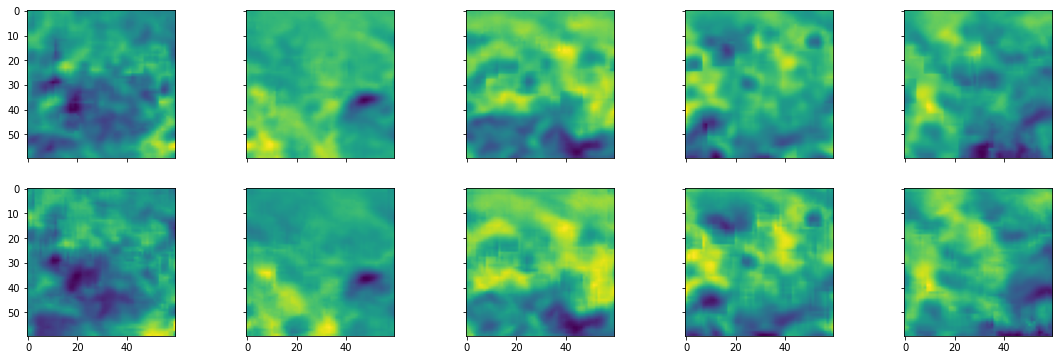

In [15]:
import matplotlib.pyplot as plt
n_samples = 5
# Plot the first 5 predictions:
# First row: Targets (ground truth)
# Second row: predictions of the trained ConvNet
fig, axs = plt.subplots(2, 5, figsize=(19, 6), sharey=True, sharex=True)
for i in range(n_samples):
  truth = val_results[0]['targets'][i, ...].squeeze()
  preds = val_results[0]['preds'][i, ...].squeeze()

  axs[0, i].imshow(truth)
  axs[1, i].imshow(preds)